In [1]:
import numpy as np
import pandas as pd
import scipy as scp
import matplotlib.pyplot as plt
import math
import matplotlib.cm as cmx
from src.mssm.models import *
np.set_printoptions(suppress=True)

In [2]:
# Load data
full_dat = None
for c in ["w","pw","nw"]:
    data_path = "/Users/joshmac/Documents/data/LD/Pre_processed/Eyetracking/hsmm/" + c + "_dat.csv"
    df = pd.read_csv(data_path,sep=";",header=0)
    full_dat = pd.concat([full_dat,df])

In [3]:
full_dat.head()

,Subject,Pupil,Time,cond,TRIAL_INDEX,RT,RT_sample,frequency,stim,sub_trial
0,sub1,-0.197867,0,W,101,741,37,91800000.0,wereld,sub1.101
1,sub1,-0.125933,20,W,101,741,37,91800000.0,wereld,sub1.101
2,sub1,-0.023172,40,W,101,741,37,91800000.0,wereld,sub1.101
3,sub1,0.069314,60,W,101,741,37,91800000.0,wereld,sub1.101
4,sub1,0.069314,80,W,101,741,37,91800000.0,wereld,sub1.101


In [4]:
# Build GAMM formula
formula = Formula(lhs=lhs("Pupil"),
                        terms=[i(),
                               l(["cond"]),
                               f(["Time"],nk=15,by="cond"),
                               fs(["Time"],nk=15,rf="Subject"),
                               fs(["Time"],nk=15,rf="sub_trial")],
                        series_id = "sub_trial",
                        data=full_dat)

/Users/joshmac/Documents/repos/mssm/src/mssm/src/python/formula.py:603: UserWarning: 105634 Pupil values (8.17%) are NA.
  warnings.warn(f"{data.shape[0] - data[NAs_flat].shape[0]} {self.get_lhs().variable} values ({round((data.shape[0] - data[NAs_flat].shape[0]) / data.shape[0] * 100,ndigits=2)}%) are NA.")


In [5]:
# Initialize GAMM
model = GAMM(formula,Gaussian())

In [6]:
# Some info about the size of this model:
print(f"Model will estimate {model.formula.n_coef} coefficients from {len(model.formula.y_flat[model.formula.NOT_NA_flat])} datapoints!")

Model will estimate 192752 coefficients from 1186824 datapoints!


In [7]:
# Fit the model
model.fit()

NAs were excluded for fitting.
Num = 12.727272727272869 - 1.4766061818745289 == 11.25066654539834
Denom = 0.4887297909914863; Lambda = 3.631871990370253
Num = 12.727272727272869 - 0.9189360325023233 == 11.808336694770546
Denom = 1.0262937506719487; Lambda = 1.815257066303998
Num = 12.727272727272869 - 1.0359630808112716 == 11.691309646461598
Denom = 1.9922067216248758; Lambda = 0.9258696636607177
Num = 368.18181818181824 - 62.35680791723442 == 305.82501026458385
Denom = 457.6422133116073; Lambda = 0.10543092437395603
Num = 24.54545454545452 - 18.636222725495518 == 5.909231819959
Denom = 256.8480835517604; Lambda = 0.0036297422840406834
Num = 163868.1818181818 - 75212.10264358645 == 88656.07917459535
Denom = 172852.30281573712; Lambda = 0.08091973343907365
Num = 10924.54545454544 - 10648.296402624905 == 276.24905192053484
Denom = 3772.9570697269583; Lambda = 0.01155154369335064
Num = 2.271346772958942 - 1.1438584597883281 == 1.127488313170614
Denom = 0.14439649605913035; Lambda = 4.9088

In [8]:
# Get predictions and parameter estimates
coef, sigma = model.get_pars()
pred = model.pred
res = model.res

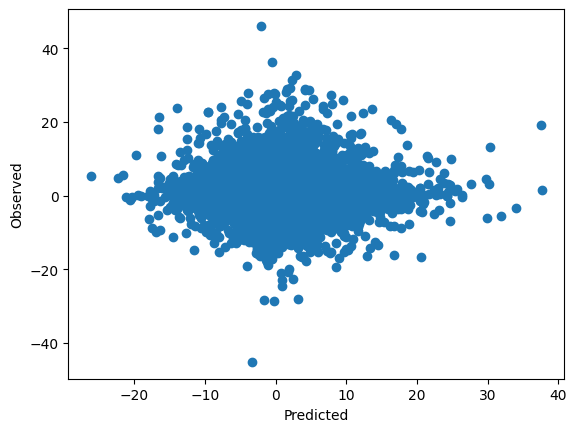

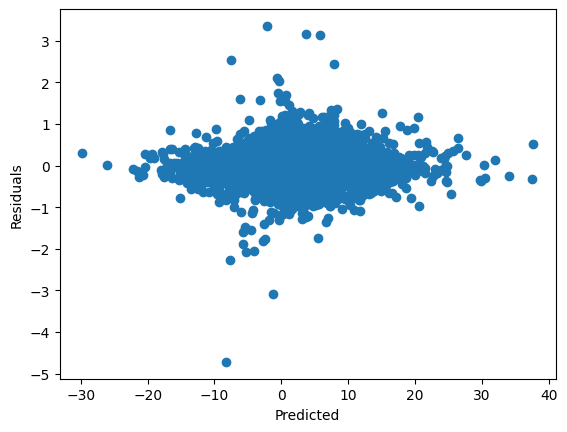

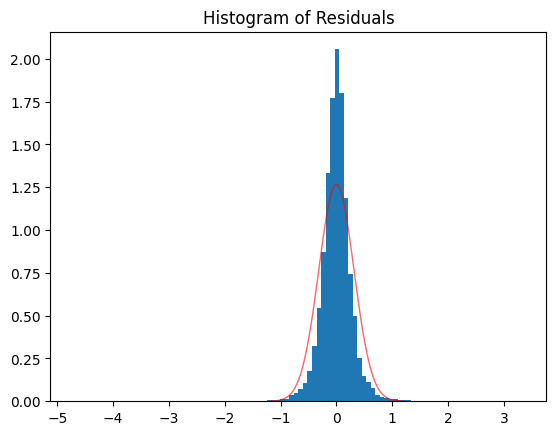

In [9]:
# Check model performance
p = 0.01
idx = np.array([ri for ri in range(len(pred))])
idx = np.random.choice(idx,int(p*len(pred)))
pred_sample = pred[idx]
res_sample = res[idx]
y_sample = model.formula.y_flat[idx]
plt.scatter(pred_sample,y_sample)
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.show()

plt.scatter(pred_sample,res_sample)
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

plt.hist(res_sample,bins=100,density=True)
x = np.linspace(scp.stats.norm.ppf(0.0001,scale=math.sqrt(sigma)),
                scp.stats.norm.ppf(0.9999,scale=math.sqrt(sigma)), 100)

plt.plot(x, scp.stats.norm.pdf(x,scale=math.sqrt(sigma)),
         'r-', lw=1, alpha=0.6)
plt.title("Histogram of Residuals")
plt.show()

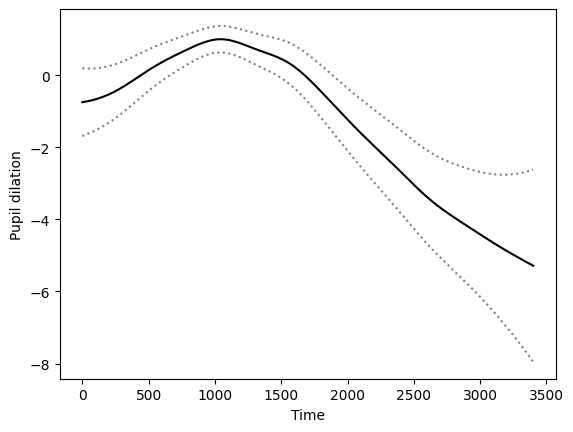

In [10]:
# Partial prediction for a single smooth
time_pred = [t for t in range(0,3420,20)]
new_dat = pd.DataFrame({"cond":["PW" for _ in range(len(time_pred))],
                        "Time":time_pred,
                        "Subject":["sub1" for _ in range(len(time_pred))],
                        "sub_trial":["sub1.101" for _ in range(len(time_pred))]})

# Make prediction using fixed effects for one condition + CI
pred,pred_mat,boundary = model.predict([2],new_dat,ci=True,alpha=0.05)

plt.plot(time_pred,pred,color='black')
plt.plot(time_pred,pred + boundary,color='grey', linestyle='dotted')
plt.plot(time_pred,pred - boundary,color='grey', linestyle='dotted')
plt.xlabel("Time")
plt.ylabel("Pupil dilation")
plt.show()

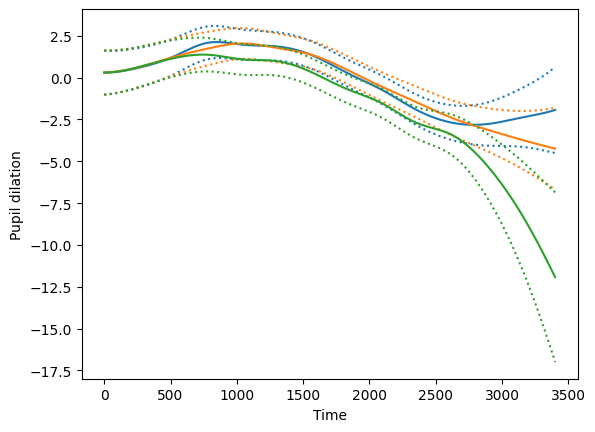

In [11]:
# Prediction for all conditions
nc = 10
colors = [cmx.tab20(x) for x in np.linspace(0.0,min(0.1*nc,1.0),nc)]

# Condition fixed effects
for ci,c in enumerate(["W","PW","NW"]):
    # Set up some new data for prediction
    time_pred = [t for t in range(0,3420,20)]
    new_dat = pd.DataFrame({"cond":[c for _ in range(len(time_pred))],
                            "Time":time_pred,
                            "Subject":["sub1" for _ in range(len(time_pred))],
                            "sub_trial":["sub1.101" for _ in range(len(time_pred))]})
    
    # Make prediction using random smooth terms only
    pred,_,b = model.predict([0,1,2],new_dat,ci=True,alpha=0.05)
    plt.plot(time_pred,pred,color=colors[ci])
    plt.plot(time_pred,pred+b,color=colors[ci], linestyle='dotted')
    plt.plot(time_pred,pred-b,color=colors[ci], linestyle='dotted')

plt.xlabel("Time")
plt.ylabel("Pupil dilation")
plt.show()

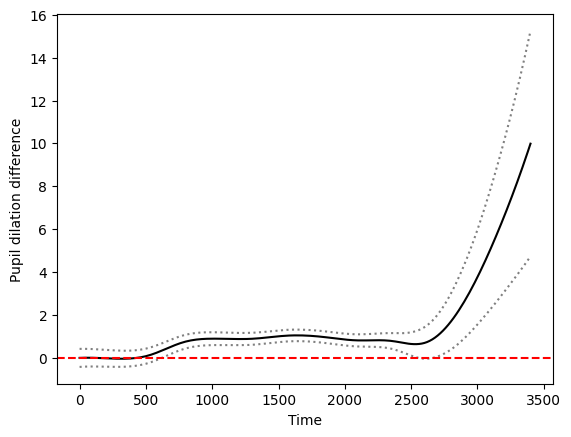

In [12]:
# Difference predictions between two conditions
time_pred = [t for t in range(0,3420,20)]
new_dat1 = pd.DataFrame({"cond":["W" for _ in range(len(time_pred))],
                         "Time":time_pred,
                         "Subject":["sub1" for _ in range(len(time_pred))],
                         "sub_trial":["sub1.101" for _ in range(len(time_pred))]})

new_dat2 = pd.DataFrame({"cond":["NW" for _ in range(len(time_pred))],
                         "Time":time_pred,
                         "Subject":["sub1" for _ in range(len(time_pred))],
                         "sub_trial":["sub1.101" for _ in range(len(time_pred))]})

diff,b = model.predict_diff(new_dat1,new_dat2,[0,1,2])

plt.plot(time_pred,diff,color='black')
plt.plot(time_pred,diff + b,color='grey', linestyle='dotted')
plt.plot(time_pred,diff - b,color='grey', linestyle='dotted')
plt.axhline(0,color="red",linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Pupil dilation difference")
plt.show()

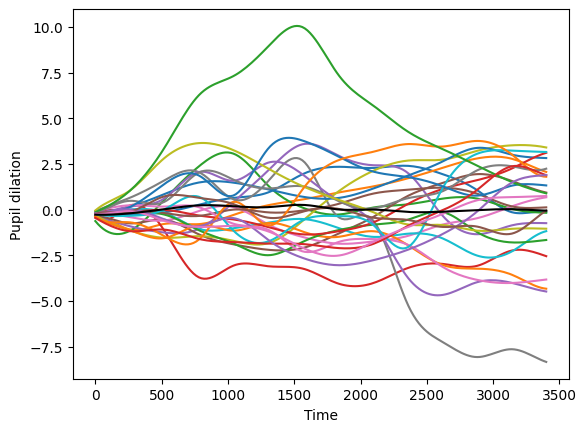

In [13]:
# Subject difference smooths - is there a subject-specific difference from the general trend?
p = 0.01
subs = np.unique(full_dat["Subject"])

avg_pred = None
for sub in subs:
    # Set up some new data for prediction
    time_pred = [t for t in range(0,3420,20)]
    new_dat = pd.DataFrame({"cond":["PW" for _ in range(len(time_pred))],
                            "Time":time_pred,
                            "Subject":[sub for _ in range(len(time_pred))],
                            "sub_trial":["sub1.101" for _ in range(len(time_pred))]})
    
    # Make prediction using random smooth terms only
    pred,_,_ = model.predict([3,5],new_dat)
    if avg_pred is None:
        avg_pred = pred
    else:
        avg_pred += pred
    plt.plot(time_pred,pred)

plt.plot(time_pred,avg_pred/len(subs),color="black")
plt.xlabel("Time")
plt.ylabel("Pupil dilation")
plt.show()

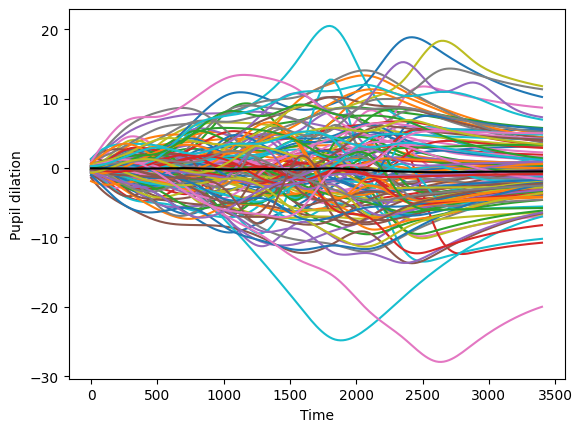

In [14]:
# Trial-level difference smooths - is there a trial-specific difference from the subject-specific difference from the general trend?
p = 0.01
trs = np.unique(full_dat["sub_trial"])
idx = np.array([ri for ri in range(len(trs))])
idx = np.random.choice(idx,int(p*len(trs)))
sel_trs = trs[idx]

avg_pred = None
for tr in sel_trs:
    # Set up some new data for prediction
    time_pred = [t for t in range(0,3420,20)]
    new_dat = pd.DataFrame({"cond":["PW" for _ in range(len(time_pred))],
                            "Time":time_pred,
                            "Subject":["sub1" for _ in range(len(time_pred))],
                            "sub_trial":[tr for _ in range(len(time_pred))]})
    
    # Make prediction using random smooth terms only
    pred,_,_ = model.predict([4,6],new_dat)
    if avg_pred is None:
        avg_pred = pred
    else:
        avg_pred += pred
    plt.plot(time_pred,pred)

plt.plot(time_pred,avg_pred/len(sel_trs),color="black")
plt.xlabel("Time")
plt.ylabel("Pupil dilation")
plt.show()

In [15]:
[p.lam for p in model.formula.penalties]

[2.525687968461451,
 11.876561871310178,
 4.360789942431305,
 0.3496987144589785,
 0.0030193159127135773,
 0.04350305419858437,
 0.0003823818769980815]